# Deep Neural Network - Milestone 3: improved model
(Baseline model and actual model separate in other file)

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit

import statistics
import math

from oversampling import smote_loop 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from tqdm import tqdm
from IPython.display import display

from data_processing import prepare_data, split_data, one_hot_encode
from helper_functions import get_metrics, get_confusion_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics, initializers
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


In [3]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Building, training and testing of the deep neural network:
The two functions below can be used to create actual model (get_model) and train and test it (train_and_predict).
For both the model itself and the train and test pipeline, there are numerous parameters that can be set.
For the "get_model" function, this includes ways to define the model's architecture.
For the "train_and_predict" function, this includes the class_weight optimizer, which defines the weight of the stroke class in the loss function, relative to the weight of the non-stroke class.

Further up in this notebook different parameters are evaluated by trying different values and run get_model and train_and_predict again.

Also, further below in this notebook a pipeline for 5-fold cross-validation (which uses these same two functions) is coded, which can be applied to get an even better evaluation of the model. This is recommended for validating the performance of different parameters, but can take much more computational time if many parameters are tried out.


In [4]:
# Actual model

def train_and_predict(model, training_data, training_labels, testing_data, testing_labels, epochs=5, class_weight=10, 
                      verbose=0, plot=True, batch_size=None):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. 
    It is possible to adjust for how many epochs the model is trained and how to weigh the sparse class.
    
    INPUT:
    
    model:        Model architecture defined before calling this function
    class_weight: Errors on the stroke class should be weighted heavier then the non-stroke class. 
                  The value defines how much more this loss is weighted. loss_weight=10 means a ratio of 1 to 10.
    verbose:      False: no text per epoch
                  True: text for each epoch
    plot:         True: show accuracy and loss over epochs in figure
                  False: no plot
                  
    OUTPUT: 
    
    predictions_train: Vector of training predictions
    predictions_test:  Vector of test predictions
    history:           Dict containing measures over epochs, including loss, accuracy, TP, FP, TN, FN, for train and test data.
                       print history.history for all measures and their keys. Return history to be able to access this model
                       information outside of the function.
    
    """
   
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # Turn off warnings (annoying bug in tensorflow)
    tf.get_logger().setLevel('ERROR')
    
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        class_weight=[{0: 1., 1: class_weight}],
                        verbose=verbose, batch_size=batch_size
                       )
    
    # Turn warnings on again 
    tf.get_logger().setLevel('INFO')

    # Predict the classes of the training data
    # Output is a continuous value between 0 and 1, so add a sort of 'hardmax' function to get it into class 0 or 1
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the loss and accuracy over epochs if requested by function call
    if plot:
        
        # Make subplots
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('loss and accuracy')
        fig.figsize = (10, 8)
        
        # Plot accuracies in one plot
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title('accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epochs')
        axs[0].legend(['train', 'test'], loc='upper left')


        # Plot the loss over epochs in the other plot
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('loss')
        axs[1].set_xlabel('epochs')
        axs[1].set_ylabel('loss')
        axs[1].legend(['train', 'test'], loc='upper left')

    
    plt.show()

    return predictions_train, predictions_test, history



In [5]:
def get_model(train_data, hidden_layers=1, nodes=[20], activation='relu', dropout_rate=[]):
    """
    Get_model creates a sequential Neural Network with layers based on the input parameters.
    
    INPUT:
    
    train_data:      Training dataset, used to define input layer's shape
    hidden_layers:   Number of hidden layers; default is 1 hidden layer.
    nodes:           List, number of nodes for each hidden layer. Length of list should be equal to amount of hidden layers, 
                     default amount of nodes is 20.
    activation:      Activation function for hidden layers, default is ReLu.
    dropout_rate:    List, rate of dropout if dropout is used. Default is empty, for if no dropout used.
    
    OUTPUT:
    model:           A full sequential model, to be compiled in the function train_and_predict().

    """
    assert len(nodes) == hidden_layers, 'length of list of nodes should be same as defined number of hidden layers'
    
    # Get the amount of input features for the nodes in the first layer
    input_shape = np.shape(train_data)[1]

    # Weights are initialized around a mean of 0, with 0.2 standard deviation
    initializer = initializers.RandomNormal(mean=0.0, stddev=0.05)
    
    # Create the model
    model = models.Sequential()

    # First layer contains as many input nodes as there are features
    model.add(Input(shape=(input_shape)))

    # Loop over the number of hidden layers to create each hidden layer
    for layer in range(hidden_layers):
        
        # Optionally add dropout layers, if the dropout_rate list is not empty
        if dropout_rate:
            assert len(dropout_rate) == hidden_layers, 'dropout_rate should be defined for each layer'
            
            # Get the dropout rate for this specific layer and apply it
            model.add(layers.Dropout(dropout_rate[layer]))
            
        # Add layer with specified number of nodes and activation function
        model.add(layers.Dense(nodes[layer], activation=activation, kernel_initializer=initializer))

    # Output layer with 1 node ( we have only 1 output class, 0 or 1 for stroke) and a sigmoid activation function
    model.add(layers.Dense(1, 'sigmoid'))

    return model




### Model without cross-validation
The code below shows the easiest way to run the model pipeline, without cross-validation. 
This can be used to quickly check how some parameters effect the different outcome metrics.

The get_metrics function returns, besides the standard accuracy, some different metrics that are more suited to evaluate the unbalanced dataset.




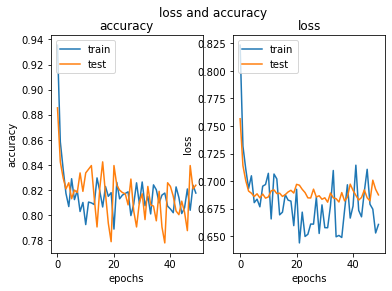

train metrics: 

accuracy: 82.9364 % 

balanced accuracy: 78.6137 %
sensitivity: 0.7383
specificity: 0.8340 

confusion matrix: 
[[2432  484]
 [  39  110]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 82.3875 % 

balanced accuracy: 71.7695 %
sensitivity: 0.6000
specificity: 0.8354 

confusion matrix: 
[[812 160]
 [ 20  30]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [6]:
# Make a model with 2 hidden layers and dropout
model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.1, 0.1])

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        class_weight = 10, plot=True, batch_size=None,
                                                        epochs=50, verbose=0)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)

### Parameter optimization

##### Class weights

The code below performs training and validation of the DNN model using different class weights.
The different output metrics are then plotted as a function of the class weights to evaluate the weighing effect.

In [7]:
# Test different class weights and plot accuracy and sensitivity

def compare_class_weights(model, train_data, train_labels, val_data, val_labels, 
                          class_weights=range(1, 21, 2), epochs=30):
    """
    This function tries out different class weights on a model and plots the different output metrics (validation accuracy, 
    balanced accuracy etc.) as a function of class_weight (No k-fold cross-validation applied).
    
    INPUT: 
    
    model:         Model as defined by the function get_model()
    train_data:    Training data
    train_labels:  Class labels of training dataset
    val_data:      Validation data
    val_labels:    Class labels of validation dataset.
    class_weights: List of weights to try; default range of 1 to 21 with steps of 2.
    epochs:        Number of epochs for training of the model. Default is 30 epochs.
    
    OUTPUT:        Shows a plot to visually compare effect of class_weights on accuracy, balanced accuracy, precision and
                    specificity.
    """
    # Initialize metrics
    accuracies_val = []
    sensitivities_val = []
    balanced_accuracies_val = []
    specificities_val = []
    
    # Loop over all class weights and train and predict on the model
    for weight in tqdm(class_weights):

        # Train and predict 
        predictions_train, predictions_val, history = train_and_predict(model, train_data, 
                                                              train_labels, val_data, val_labels,
                                                              epochs=epochs, verbose=0, plot=False,
                                                              class_weight=weight)

        # Get the metrics
        accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
        conmat, sensitivity, specificity = get_confusion_metrics(val_labels, predictions_val)
        
        # Append all the accuracies to their respective lists
        accuracies_val.append(accuracy_val)
        balanced_accuracies_val.append(balanced_accuracy_val)
        sensitivities_val.append(sensitivity)
        specificities_val.append(specificity)
    
    ## Plot metrics over  class weights.
    plt.plot(class_weights, accuracies_val)
    plt.plot(class_weights, balanced_accuracies_val)
    plt.plot(class_weights, sensitivities_val)
    plt.plot(class_weights, specificities_val)
    plt.ylim(0, 1)
    plt.title('Effect of class weights on different output metrics in validation data')
    plt.ylabel('proportions')
    plt.xlabel('Relative weight of stroke class')
    plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
    plt.show() 

model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.1, 0.1])

compare_class_weights(model, train_data, train_labels, val_data, val_labels, 
                      class_weights=range(1, 30, 2), epochs=50)



  0%|          | 0/15 [00:03<?, ?it/s]


KeyboardInterrupt: 

### k-fold cross-validation pipeline

The pipeline below is used for k-fold cross-validation, a way to optimize model evaluation. Validation is repeated k times, each time using a different split of the data. This both increases the amount of data used for validation and gives more stable metrics since the average is taken over all k iterations.

The function "k_fold_validation" contains the full pipeline and returns the relevant metrics.


In [ ]:
# Datasets for k-fold cross-validation
# re-importing the data is not necessary, but is written here just in case the previous parts were skipped (not recommended).
data = prepare_data('healthcare-dataset-stroke-data.csv')

# Get cross-validation data and test_data (cross validation data will be further split into train and validation data in
# function)
X, test_data, y, test_labels = split_data(data, split_size=(0.8, 0.2))

In [23]:
def k_fold_validation(X, y, model, k=5, class_weight=10, epochs=5, batch_size=None, to_return=['metrics', 'history']):
    """
    Uses k-fold cross-validation to estimate average training and validation accuracies over different splits. It uses all 
    training/validation data and resplits it 5 times into a training and validation set. It then performs training and 
    testing of the model and takes the average of accuracies over all 5 folds.
    
    INPUT:
    
    X:              Data array containing all features of training and validation data for cross-validation
    y:              Labels of X data
    model:          Model as returned by the function get_model()
    k:              Number of folds for cross-validation
    class_weight:   Relative weight of stroke class cost for model training (ratio = 1:class_weight). Default is 10.
    epochs:         Number of epochs
    batch_size:     Size of batches for mini-batch gradient descent learning, default=None (train on whole dataset)
    to_return:      List with either one or two strings:
                    'metrics': returns all relevant metrics after all epochs are finished, averaged over k splits.
                    'history': returns the loss and accuracy of train and validation data after each epoch, 
                               averaged over k splits.
    
    OUTPUT:         Depends on the value from to_return (see INPUT): ['metrics', 'history']. The returns are both tuples.
    
    metrics (7-item tuple): 
                    - avg_acc_train: average accuracy training folds
                    - avg_bal_acc_train, average balanced accuracy training folds
                    - avg_acc_val, average accuracy validation folds
                    - avg_bal_acc_val, average balanced accuracy validation folds
                    - avg_sens, average sensitivity for validation folds
                    - avg_spec, average specificity for validation folds
                    - conmat, confusion matrix of validation fold predictions.
                    
    history (4-item tuple):
                    - avg_loss_over_epochs: average loss for each epoch training folds
                    - avg_acc_over_epochs, average accuracy for each epoch training folds
                    - avg_loss_over_epochs_val: average loss for each epoch validation folds
                    - avg_acc_over_epochs_val: average accuracy for each epoch validation folds
    
    """
    # Set metrics and history to None, so that there is something to return if they are not actually requested
    metrics_mean = None
    history = None
    
    # Initialize metrics if it's requested later
    if 'metrics' in to_return:
        accuracies_train = []
        balanced_accuracies_train = []
        accuracies_val = []
        balanced_accuracies_val = []
        sensitivities = []
        specificities = []
        conmats = np.zeros((2,2))
    
    if 'history' in to_return:    
        data_per_epoch = []      
    
    # Get object that splits the data in 5 equal stratified folds
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)
    
    # Loop over the training and test indexes of those 5 datasets
    for train_index, test_index in sss.split(X, y):
        
        # Split data and labels into training and testing data and labels
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        # Train and predict model.
        predictions_train, predictions_val, history = train_and_predict(model, x_train, y_train, x_val, y_val,
                                                                        epochs=epochs, class_weight=class_weight, 
                                                                        batch_size=batch_size, verbose=0, plot=False)
        # Append the histories if requested
        if 'history' in to_return:
            
            # Store history of each split
            data_per_epoch.append(history)
        
        # Calculate metrics if requested
        if 'metrics' in to_return:
            
            # Get metrics for this split
            accuracy_train, balanced_accuracy_train = get_metrics(y_train, predictions_train, verbose=False)
            accuracy_val, balanced_accuracy_val = get_metrics(y_val, predictions_val, verbose=False)
            
             # Store metrics for this split
            accuracies_train.append(accuracy_train)
            balanced_accuracies_train.append(balanced_accuracy_train)
            accuracies_val.append(accuracy_val)
            balanced_accuracies_val.append(balanced_accuracy_val)
            
            # Get confusion matrix to calculate sensitivity and specificity.
            conmat, sensitivity, specificity = get_confusion_metrics(y_val, predictions_val)

            # Return the confusion matrix by adding it to our empty array and add sensitivies and specificities
            conmats += np.array(conmat)
            sensitivities.append(sensitivity)
            specificities.append(specificity)
    

    # Do the last calculations needed for metrics if it's going to be returned
    if 'metrics' in to_return:
        
        # Append all metrics together
        metrics_all = [accuracies_train, balanced_accuracies_train, accuracies_val, 
                       balanced_accuracies_val, sensitivities, specificities]
        metrics_mean = []
        
        # Loop over all metrics and compute and store their mean over all k splits.
        for metric in metrics_all:
            
            # Compute average metrics over all k splits.
            metrics_mean.append(statistics.mean(metric))
        
        # Divide the confusion matrixes by the number of folds, as we've summed over each fold
        metrics_mean.append(conmats / k)
        
        # Transform the metrics to a tuple for easy unpacking
        metrics_mean = tuple(metrics_mean)
        
    # Do the last calculations for history if it's going to be returned
    if 'history' in to_return:
        
        # List to append all metrics to
        history_metrics = []
        
        # The history of accuracy and loss over epochs is averaged here over all k folds.
        for metric_names, metric_values in history.history.items():
            # compute average loss and accuracy over all k splits for each epoch
            metric_history = np.zeros(len(metric_values))
        
            # Loop over the list of history dictionaries for each k split
            for history_dict in data_per_epoch:
                # add up data of each split for the loss and accuracy of both validation and training data.
                metric_history = metric_history + np.array(history_dict.history[metric_names])
                
            # Divide the sums by k to get the average
            history_metrics.append(metric_history / k)
        
        # Story history as tuple for packed return
        history = tuple(history_metrics)
        
    return metrics_mean, history_metrics
    


### Validation of the model with k-fold cross-validation.

The cells below can be used to run the k-fold cross-validation pipeline and print the results. 

For k-fold cross-validation, we do not want to split the non-test data into training and validation data beforehand, because this happens k times during cross-validation. Therefore we have to resplit the data into a dataset for cross-validation and a test-set. 

In [24]:
# Create model
model = get_model(X, hidden_layers=2, nodes=[25, 25], dropout_rate=[0.1, 0.1])

# Number of training epochs.
epochs = 50

# Perform 5-fold cross-validation
metrics, history = k_fold_validation(np.array(X), np.array(y), model, k = 5, batch_size=None,
                                     class_weight = 15, epochs = epochs, to_return=['metrics','history'])

# Unpack tuples
avg_loss_over_epochs, avg_acc_over_epochs, avg_loss_over_epochs_val, avg_acc_over_epochs_val = history
avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec, conmat = metrics

average accuracy training data: 73.1661 %
average accuracy validation data: 73.3985 % 

average balanced accuracy training data: 80.1084 %
average balanced accuracy validation data: 77.2410 %
sensitivity: 0.8150
specificity: 0.7298 

confusion matrix: 
[[567.8 210.2]
 [  7.4  32.6]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



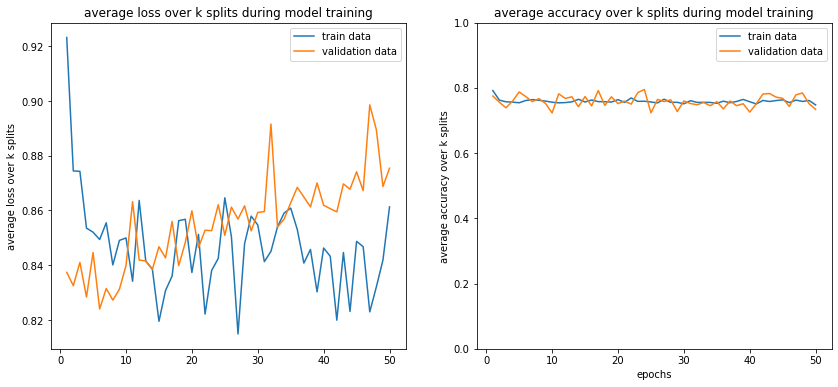

In [25]:
#  Print metrics

print(f'average accuracy training data: {avg_acc_train*100:.4f} %')
print(f'average accuracy validation data: {avg_acc_val*100:.4f} % \n')

print(f'average balanced accuracy training data: {avg_bal_acc_train*100:.4f} %')
print(f'average balanced accuracy validation data: {avg_bal_acc_val*100:.4f} %')
print(f'sensitivity: {avg_sens:.4f}')
print(f'specificity: {avg_spec:.4f} \n')
print('confusion matrix: ')
print(f'{conmat} \n')
print('[["True Negative", "False Positive"] \n ["False Negative", "True Positive"]] \n')

# Plot the loss and accuracy during learning of the model, averaged over k splits using cross-validation
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
fig.figsize = (10, 8)

# Get the number of epochs for horizontal axis.
epochs = len(avg_loss_over_epochs)
x = range(1, epochs + 1)

# Plot the average loss for each epoch
axs[0].plot(x, avg_loss_over_epochs)
axs[0].plot(x, avg_loss_over_epochs_val)
axs[0].set_title('average loss over k splits during model training')
axs[0].set_ylabel('average loss over k splits')
axs[0].legend(['train data', 'validation data'], loc='upper right')

# Plot average accuracy of train and validation data for each epoch
axs[1].plot(x, avg_acc_over_epochs)
axs[1].plot(x, avg_acc_over_epochs_val)
axs[1].set_title('average accuracy over k splits during model training')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('average accuracy over k splits')
axs[1].legend(['train data', 'validation data'], loc='upper right')
axs[1].set_ylim([0,1])
plt.show()

### Data augmentations - oversampling

In the following cells, oversampling, a data augmentation technique is applied. By generating new generic samples of the minority class, there is a chance the model will be trained better and perform more accurate. 


In [29]:
# Get the data and clean it.
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = False, normalize = True)

# Replace binary values with clear names
data['hypertension'].replace(to_replace = (0, 1), value = ('normal', 'hypertension'), inplace = True)
data['heart_disease'].replace(to_replace = (0, 1), value = ('healthy', 'heart disease'), inplace = True)

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))


In [25]:
# Unpack the smote_loop
list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, 0.1, 0.96, 0.05)

print('shape training data:', list_data[0].shape)

# One-hot encode two columns of the validation data
val_data = one_hot_encode(val_data)

print('shape validation data:', val_data.shape)

shape training data: (3207, 22)
shape validation data: (1022, 22)


18it [01:32,  5.15s/it]


### Validation of different oversampling rates.

In [22]:
# Create the model object to test the data augmentation on.
model = get_model(list_data[0], hidden_layers=1, nodes=[25], activation='relu', dropout_rate=[])

# Initiate the oversampling lists
oversampling_val = []
oversampling_val_bal = []
oversampling_sens = []
oversampling_spec = []

# Loop over every dataset and labels with different ratios. ratio's as specified in list_ratio (cell above).
for data_res, labels_res in tqdm(zip(list_data, list_labels)):
    
    # Train and predict the network 
    predictions_train, predictions_val, history = train_and_predict(model, data_res, labels_res, val_data, val_labels,epochs=30,
                                                                    verbose=0, plot=False, class_weight=1)
    
    # Get metrics from the network
    accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
    conmat, sensitivity, specificity = get_confusion_metrics(val_labels, predictions_val)
    
    # Append to lists 
    oversampling_val.append(accuracy_val)
    oversampling_val_bal.append(balanced_accuracy_val)
    oversampling_sens.append(sensitivity)
    oversampling_spec.append(specificity)

18it [01:09,  3.84s/it]


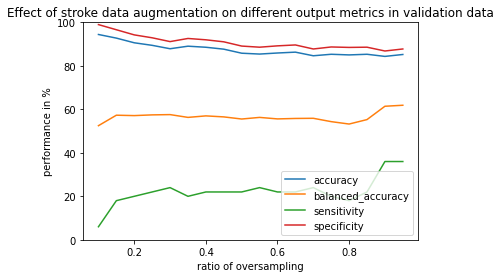

In [12]:
# Plot metrics for different oversampling ratios in percentages
plt.plot(list_ratio, np.array(oversampling_val) * 100)
plt.plot(list_ratio, np.array(oversampling_val_bal) * 100)
plt.plot(list_ratio, np.array(oversampling_sens) * 100)
plt.plot(list_ratio, np.array(oversampling_spec) * 100)

plt.ylim(0, 100)
plt.title('Effect of stroke data augmentation on different output metrics in validation data')
plt.ylabel('performance in %')
plt.xlabel('ratio of oversampling')
plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
plt.show()  


### Evaluation of the effect of both oversampling and class weights

Oversampling and class weights are both methods to deal with imbalance in the data. However, if too much sensitivity is reached by these methods, this can have a negative effect on the selectivity, leading to a lower balanced accuracy.

The code below trains and tests a neural network many times, each time using a different oversampling rate and class weights. The balanced accuracy is then visualised in a 3D plot for all different combinations of oversampling and class weights, in order to find the optimal combination of both parameters.

In [8]:
# TODO: Deze hele cell lijkt me een beetje overdreven uitgebreid uitgeschreven. 
# Misschien iets met np.linspace of gewoon range?

# start stop step, always a little bit higher than the last actual number
oversampling_start = 0.1
oversampling_stop = 0.61
oversampling_step = 0.05

class_weight_start = 1
class_weight_stop = 21
class_weight_step = 2

# Calculate lengths for matrices 
# Hoezo berekenen jullie dit op deze manier? TODO
oversampling_length = math.ceil(( oversampling_stop - oversampling_start ) / oversampling_step)
class_weight_length = math.ceil((class_weight_stop - class_weight_start ) / class_weight_step)

print(np.zeros((oversampling_length, class_weight_length)).shape)
print('(oversampling ratio x class weight ratio)')

(11, 10)
(oversampling ratio x class weight ratio)


In [9]:
# Get the data and clean it again for the plot
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = False, normalize = True)

# Replace binary values with clear names
data['hypertension'].replace(to_replace = (0, 1), value = ('normal', 'hypertension'), inplace = True)
data['heart_disease'].replace(to_replace = (0, 1), value = ('healthy', 'heart disease'), inplace = True)

# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))


In [10]:
# Unpack the smote_loop with the oversampling parameters
list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, 
                                                oversampling_start, oversampling_stop, oversampling_step)

print('shape training data:', list_data[0].shape)

# One-hot encode two columns of the validation data
val_data = one_hot_encode(val_data)

print('shape validation data:', val_data.shape)

shape training data: (3207, 22)
shape validation data: (1022, 22)


In [13]:
# Test different class weights and plot accuracy and sensitivity

# Matrices for the accuracies: 2D array: rows = oversampling, columns is class_weight
accuracies = np.zeros((oversampling_length, class_weight_length))
sensitivities = np.zeros((oversampling_length, class_weight_length))
balanced_accuracies = np.zeros((oversampling_length, class_weight_length))
specificities = np.zeros((oversampling_length, class_weight_length))

# Loop over different dataset oversampling ratio's
for i, (data_res, labels_res) in enumerate(tqdm(zip(list_data, list_labels))):
    # Loop over different class weights
    for j, weight in enumerate(tqdm(range(class_weight_start, class_weight_stop, class_weight_step))):
        # Train and predict
        predictions_train, predictions_val, history = train_and_predict(model, data_res, 
                                                              labels_res, val_data, val_labels,
                                                              epochs=30, verbose=0, plot=False,
                                                              class_weight=weight)
    
        # Get metrics
        accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
        conmat, sensitivity, specificity = get_confusion_metrics(test_labels, predictions_val)
        
        accuracies[i, j] = accuracy_val
        balanced_accuracies[i, j] = balanced_accuracy_val
        sensitivities[i, j] = sensitivity
        specificities[i, j] = specificity 
        


0it [00:00, ?it/s]
100%|██████████| 10/10 [00:35<00:00,  3.53s/it]
1it [00:35, 35.32s/it]
100%|██████████| 10/10 [00:36<00:00,  3.61s/it]
2it [01:11, 35.75s/it]
100%|██████████| 10/10 [00:39<00:00,  3.91s/it]
3it [01:50, 37.30s/it]
100%|██████████| 10/10 [00:39<00:00,  3.92s/it]
4it [02:29, 38.04s/it]
100%|██████████| 10/10 [00:41<00:00,  4.18s/it]
5it [03:11, 39.39s/it]
100%|██████████| 10/10 [00:38<00:00,  3.85s/it]
6it [03:49, 39.10s/it]
100%|██████████| 10/10 [00:43<00:00,  4.31s/it]
7it [04:33, 40.39s/it]
100%|██████████| 10/10 [00:43<00:00,  4.39s/it]
8it [05:16, 41.50s/it]
100%|██████████| 10/10 [00:44<00:00,  4.46s/it]
9it [06:01, 42.47s/it]
100%|██████████| 10/10 [00:45<00:00,  4.54s/it]
10it [06:46, 43.36s/it]
100%|██████████| 10/10 [00:45<00:00,  4.54s/it]
11it [07:32, 41.12s/it]


In [14]:
print('accuracies:\n', accuracies)
print('balanced_accuracies:\n', balanced_accuracies)
print('sensitivities\n:', sensitivities)
print('specificities:\n', specificities)

accuracies:
 [[0.94911937 0.88943249 0.82289628 0.78962818 0.77495108 0.7407045
  0.69569472 0.70645793 0.67906067 0.64872798]
 [0.92857143 0.87377691 0.81898239 0.75440313 0.72113503 0.70058708
  0.63209393 0.61545988 0.64579256 0.60958904]
 [0.90508806 0.84344423 0.78375734 0.76908023 0.62035225 0.63111546
  0.59197652 0.60273973 0.54109589 0.65068493]
 [0.88551859 0.82681018 0.78767123 0.69765166 0.74168297 0.6409002
  0.59589041 0.61937378 0.58023483 0.51369863]
 [0.87475538 0.81604697 0.77299413 0.72994129 0.61643836 0.59197652
  0.58708415 0.59589041 0.58610568 0.56751468]
 [0.86692759 0.79941292 0.77201566 0.73776908 0.63796477 0.61350294
  0.68395303 0.55675147 0.56066536 0.57632094]
 [0.86105675 0.74853229 0.74363992 0.66438356 0.68297456 0.61741683
  0.57142857 0.52348337 0.4109589  0.53816047]
 [0.84931507 0.77005871 0.70841487 0.68395303 0.6223092  0.63307241
  0.52054795 0.38649706 0.54598826 0.5332681 ]
 [0.84540117 0.78571429 0.67808219 0.65753425 0.65753425 0.57240705
 

In [32]:
# find max values and their indexes 
bal_acc_max_index = np.unravel_index(balanced_accuracies.argmax(), balanced_accuracies.shape)
sens_max_index = np.unravel_index(sensitivities.argmax(), sensitivities.shape)

print(bal_acc_max_index)
print(sens_max_index)


(2, 6)
(10, 7)


In [36]:

# Interactive plotting in separate window
%matplotlib qt 

# make 3D figure
fig = plt.figure(figsize=(10,10))

# create 3 axises
ax = fig.add_subplot(111, projection='3d')

X0 = np.arange(class_weight_start, class_weight_stop, class_weight_step)
Y0 = np.arange(oversampling_start, oversampling_stop, oversampling_step)

# find the optimal values of the oversampling ratio and the class weight ratio
bal_acc_optimal_oversample = Y0[bal_acc_max_index[0]]
bal_acc_optimal_class_weight = X0[bal_acc_max_index[1]]

print(bal_acc_optimal_oversample)
print(bal_acc_optimal_class_weight)

# make a grid, in order to plot every point
X, Y = np.meshgrid(X0, Y0)

Z = balanced_accuracies 

# make plot 
actual_plot = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

# add colorbar
fig.colorbar(actual_plot, shrink=0.5, aspect=5)

# Label X and Y
ax.set_xlabel('Class weight ratio')
ax.set_ylabel('Oversampling ratio')
ax.set_zlabel('Performance in percentage')

# plt.show()

0.20000000000000004
13


Text(0.5, 0, 'Performance in percentage')

### Ensemble method for Deep Neural Network, where each network is trained on a subset of non-stroke data and all stroke data.

In [48]:
def network_ensembles(model, data, 
                      nr_splits=10, class_weight=1, epochs=50, batch_size=None):
    """
    This function makes a forest of Classifiers, each trained on all of the data of patients with strokes and only part of the 
    sample of patients without strokes. 
    
    INPUT: 
    
    data:       Tuple with 4 data items in order: training_data, training_labels, testing_data, testing_labels.
    nr_splits:  The number of trees in the forest; this also determines how often the data is split.
    
    OUTPUT:
    
    train_predictions, test_predictions:
                The final predictions of the forest for both training and testing data, determined by majority vote. 
    """
    training_data, training_labels, testing_data, testing_labels = data 
    
    # Seperate data from patients with stroke from no stroke by making a mask based on the labels 
    stroke_mask = train_labels == 1
    stroke_data = train_data[stroke_mask]

    # This selects the opposite of the mask, to get patients without stroke
    non_stroke_data = train_data[~stroke_mask]
    
    # Get variables to sum to later
    train_predicted = 0
    test_predicted = 0

    # Get the ratio that we will have to use for sampling the dataset for nr_splits amount of splits
    ratio = 1 / nr_splits

    # For the amount of splits, sample a new part of the data and train a new decision tree on it
    for split in range(nr_splits):

        # Get a sample of the non-stroke data
        sample_non_stroke = non_stroke_data.sample(frac = ratio)

        # Remove this sample from the dataset so we eventually use all the data to train our forest of trees
        non_stroke_data.drop(sample_non_stroke.index)

        # Append the non-stroke sample and our data for stroke patients to actually train the tree on
        mini_train = pd.concat((sample_non_stroke, stroke_data))

        # Get the labels belonging to this mini-train set
        mini_train_labels = training_labels[mini_train.index]

        
        # compile the model.
        model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
        # Turn off warnings (annoying bug in tensorflow)
        tf.get_logger().setLevel('ERROR')
        # Train the model for a number of epochs on the batch data.
        history = model.fit(mini_train, mini_train_labels, epochs=epochs, 
                            class_weight=[{0: 1., 1: class_weight}],
                            verbose=0, batch_size=batch_size
                           )
        # Turn warnings on again 
        tf.get_logger().setLevel('INFO')

        # Predict the classes of the whole training data
        # Output is a continuous value between 0 and 1, so add a sort of 'hardmax' function to get it into class 0 or 1
        predictions_train = model.predict(training_data) >= 0.5

        # Predict the classes on the testing data
        predictions_test = model.predict(testing_data) >= 0.5
        
        # Add the predicted scores for this model to the total scores over all trees
        train_predicted += predictions_train
        test_predicted += predictions_test

    # Calculate if the majority of the trees classified the training and testing sample as stroke or not
    train_predictions = train_predicted / nr_splits >= 0.5
    test_predictions = test_predicted / nr_splits >= 0.5

    #  Return the predictions
    return train_predictions, test_predictions


model = get_model(train_data, hidden_layers=2, nodes=[25, 15], dropout_rate=[0.1, 0.1])

data = train_data, train_labels, test_data, test_labels

predictions_train, predictions_test = network_ensembles(model, data, class_weight=1 , nr_splits=5)


# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)

train metrics: 

accuracy: 77.1289 % 

balanced accuracy: 83.8406 %
sensitivity: 0.9128
specificity: 0.7641 

confusion matrix: 
[[2228  688]
 [  13  136]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 76.1252 % 

balanced accuracy: 70.3745 %
sensitivity: 0.6400
specificity: 0.7675 

confusion matrix: 
[[746 226]
 [ 18  32]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

